In [ ]:
# %pip install numpy tifffile matplotlib scikit-image pyocclient

In [1]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import dilation, disk

In [2]:
import owncloud
import os

if not os.path.exists('data'):
    print('Creating directory for data')
    os.mkdir('data')

if not os.path.exists('data/single_cell.tif'):
    oc = owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/QXTKzW6UGeozcUN')
    oc.get_file('/', 'data/single_cell.tif');

In [3]:
data = tifffile.imread('data/single_cell.tif')

# **Multi-Pixel Data Extraction to 1D Calcium Trace**  

In this unit, we focus on a common task in calcium imaging: converting multi-pixel fluorescence data from a single neuron into a single 1D trace over time. While each image frame may contain dozens or hundreds of pixels representing a cell, our goal is to summarize this data into a trace that reflects the neuron’s activity. 

---

## **Identifying Active Pixels Using Thresholding**  

To generate a meaningful 1D trace from an image, the first step is to determine which pixels represent the cell’s signal. This involves thresholding fluorescence values to distinguish cell-related activity from background noise. Thresholding helps isolate the most relevant parts of the cell, so that analysis is based on pixels that contribute meaningful information. 

| **Code**                              | **Description**                                                                       |
| :------------------------------------ | :------------------------------------------------------------------------------------ |
| `np.std(data, axis=0)`                | Compute the **standard deviation** projection across all frames.                      |
| `projection > 1000`                   | Create a **binary mask** where the projection exceeds 1000.                           |
| `plt.imshow(projection, cmap='gray')` | Display the **projection** as an image using grayscale.                               |
| `plt.contour(mask_abs, colors='red')` | Plot the **contour** of the mask.                                |
| `np.percentile(projection, 10)`       | Compute the **10th percentile** of the projection.                                    |
| `np.where(mask)`                      | Get the **coordinates** of pixels where the mask is True.                             |
| `plt.scatter(x_pixels, y_pixels)`     | Plot the **coordinates** of the pixels from the mask as a scatter plot.               |
| `dilation(mask, disk(3))`             | Perform **dilation** on the mask with a disk of size 3.                               |
| `outer & ~inner`                      | Create a **neuropil mask** by subtracting the inner dilation from the outer dilation. |

*How do I identify cell boundaries with manual thresholding?*

**Example** Create a contour mask over regions where the standard deviation across time exceeds 1000.

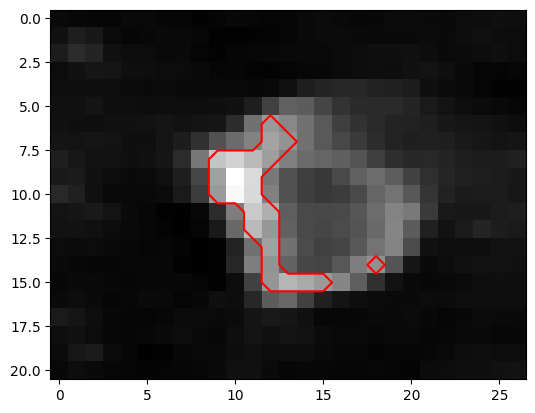

In [4]:
projection = np.std(data, axis=0)
mask_abs = projection > 1000
plt.imshow(projection, cmap='gray')
plt.contour(mask_abs, colors='red')

Create a contour mask over regions where the mean across time exceeds 2000.

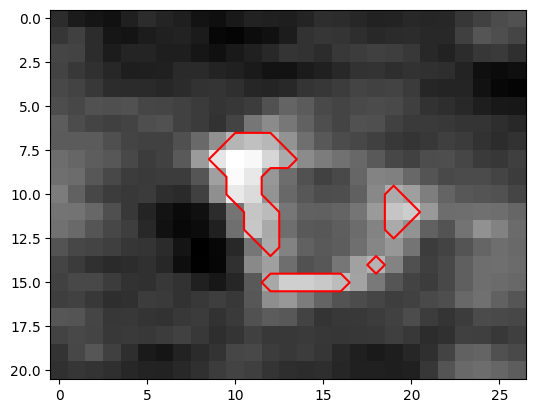

In [5]:
projection = np.mean(data, axis=0)
mask_abs = projection > 2000
plt.imshow(projection, cmap='gray')
plt.contour(mask_abs, colors='red')

Create a contour mask over regions where the median across time exceeds 2000.

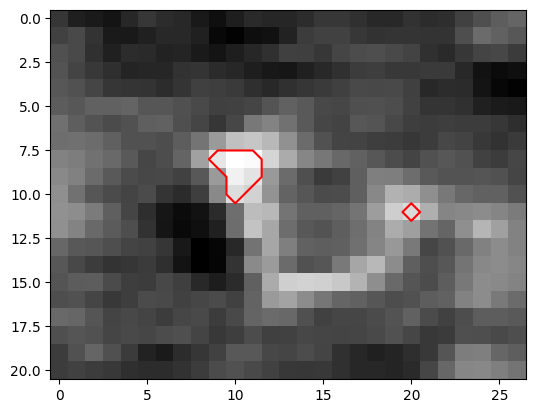

In [6]:
projection = np.median(data, axis=0)
mask_abs = projection > 2000
plt.imshow(projection, cmap='gray')
plt.contour(mask_abs, colors='red')

Create a contour mask over regions where the standard deviation across time exceeds 500.

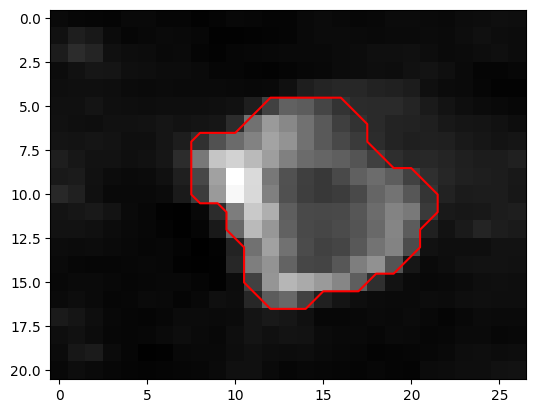

In [7]:
projection = np.std(data, axis=0)
mask_abs = projection > 500
plt.imshow(projection, cmap='gray')
plt.contour(mask_abs, colors='red')

*How do I identify cell boundaries with automatic thresholding?*

**Example** Create a contour mask over regions where the standard deviation exceeds 3-Sigma threshold.

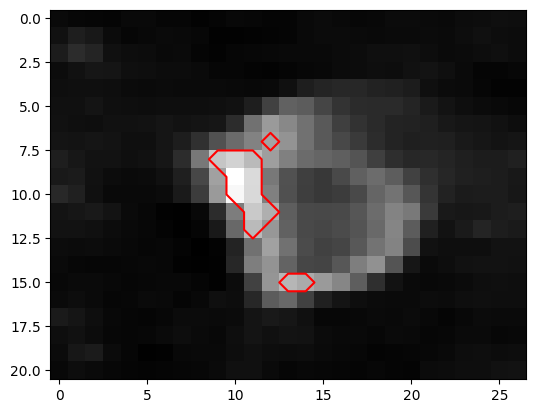

In [8]:
projection = np.std(data, axis=0)
threshold_val = np.mean(projection) + 3.*np.std(projection)
mask_percentile = projection > threshold_val
plt.imshow(projection, cmap='gray')
plt.contour(mask_percentile, colors='red')

Create a contour mask over regions where the standard deviation across time is above the 10th percentile.

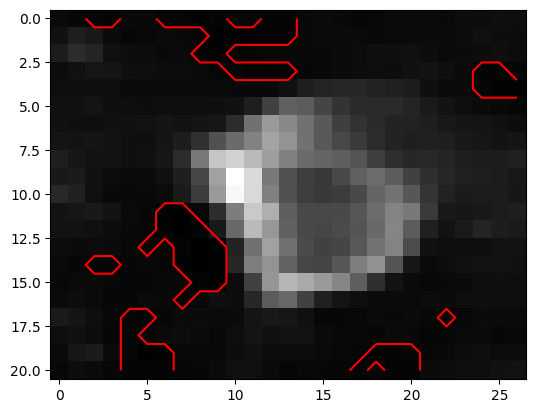

In [9]:
projection = np.std(data, axis=0)
threshold_val = np.percentile(projection, 10)
mask_percentile = projection > threshold_val
plt.imshow(projection, cmap='gray')
plt.contour(mask_percentile, colors='red')

Create a contour mask over regions where the standard deviation across time is above the 80th percentile.

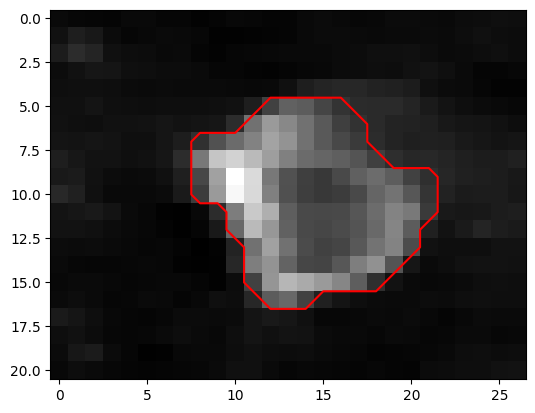

In [10]:
projection = np.std(data, axis=0)
threshold_val = np.percentile(projection, 80)
mask_percentile = projection > threshold_val
plt.imshow(projection, cmap='gray')
plt.contour(mask_percentile, colors='red')

*How do I make sure that I have all the pixels within the cell?*

**Example** Show all the pixels where the below projection exceeds 1000.

In [11]:
projection = np.std(data, axis=0)

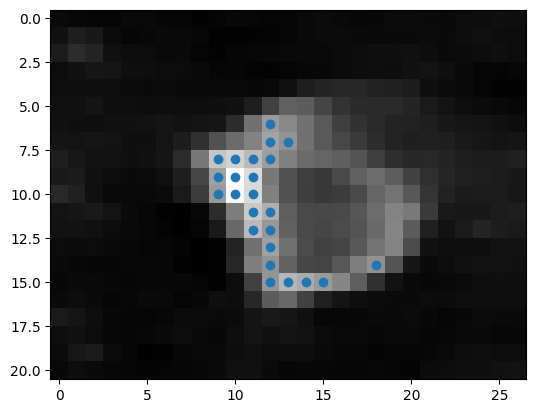

In [12]:
mask = projection > 1000
y_pixels, x_pixels = np.where(mask)
plt.imshow(projection, cmap='gray')
plt.scatter(x_pixels, y_pixels)

Show all the pixels where the below projection is above 5th percentile.

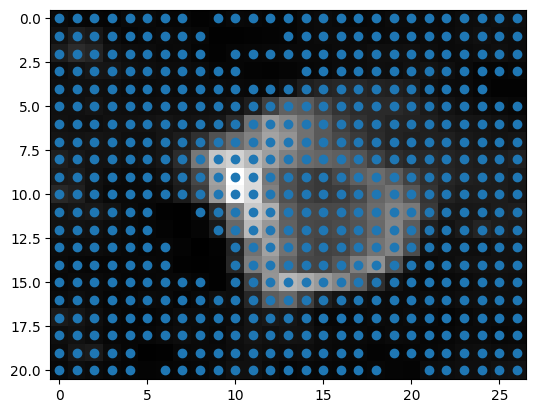

In [14]:
mask = projection > np.percentile(projection, 5)
y_pixels, x_pixels = np.where(mask)
plt.imshow(projection, cmap='gray')
plt.scatter(x_pixels, y_pixels)

Show all the pixels where the below projection is above 80th percentile.

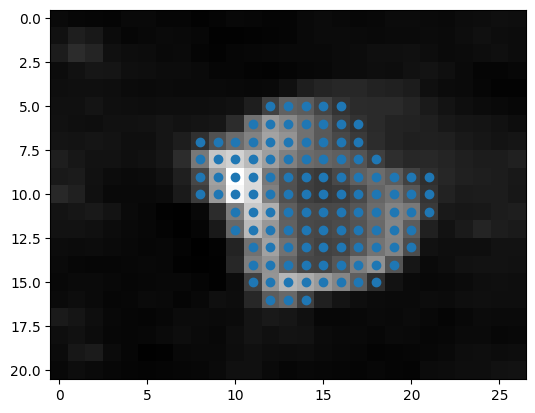

In [15]:
mask = projection > np.percentile(projection, 80)
y_pixels, x_pixels = np.where(mask)
plt.imshow(projection, cmap='gray')
plt.scatter(x_pixels, y_pixels)

*How do I set neuropil area around the cell?*

**Example** Create a 1-pixel-wide neuropil ring around the cell mask and 2-pixel away.

In [16]:
mask = projection > 1000

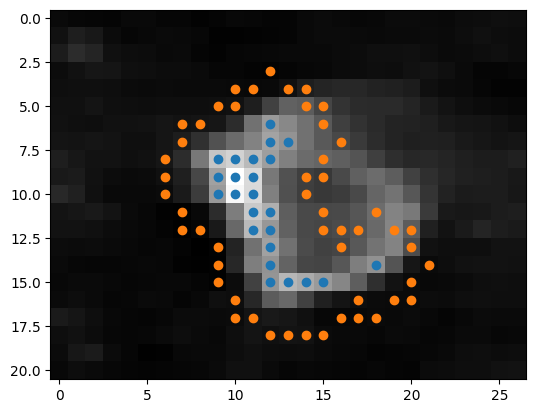

In [18]:
outer = dilation(mask, disk(3))
inner = dilation(mask, disk(2))
npil = outer & ~inner

npil_y, npil_x = np.where(npil)
cell_y, cell_x = np.where(mask)


plt.imshow(projection, cmap='gray')
plt.scatter(cell_x, cell_y)
plt.scatter(npil_x, npil_y)

Create a 1-pixel-wide neuropil ring 7 pixels away from the cell mask.

In [19]:
threshold_val = np.mean(projection) + 3.*np.std(projection)
mask = projection > threshold_val

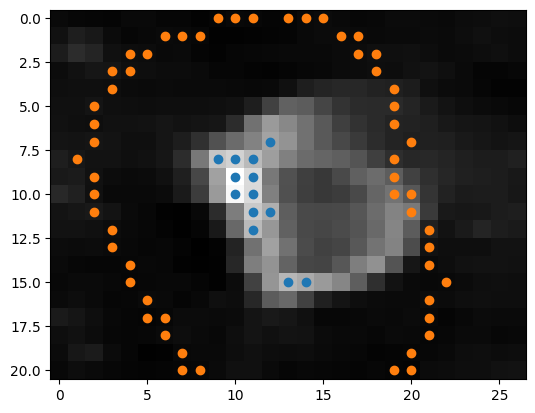

In [20]:
outer = dilation(mask, disk(8))
inner = dilation(mask, disk(7))
npil = outer & ~inner

npil_y, npil_x = np.where(npil)
cell_y, cell_x = np.where(mask)


plt.imshow(projection, cmap='gray')
plt.scatter(cell_x, cell_y)
plt.scatter(npil_x, npil_y)

Create a 3-pixel-wide neuropil ring starting 2 pixels away from the cell mask

In [21]:
threshold_val = np.percentile(projection, 80)
mask = projection > threshold_val

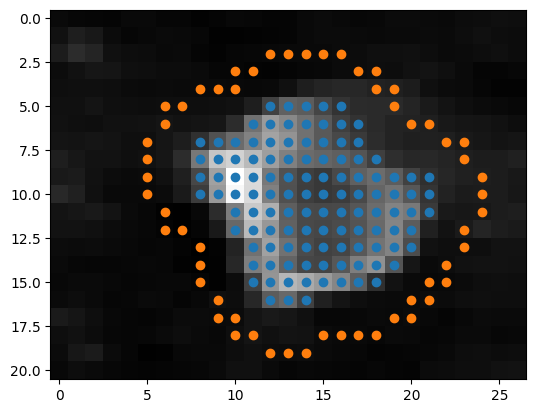

In [22]:
outer = dilation(mask, disk(3))
inner = dilation(mask, disk(2))
npil = outer & ~inner

npil_y, npil_x = np.where(npil)
cell_y, cell_x = np.where(mask)


plt.imshow(projection, cmap='gray')
plt.scatter(cell_x, cell_y)
plt.scatter(npil_x, npil_y)

## **Extracting Pixel Time Series**  

Once the active pixels have been identified, the next step is to extract their fluorescence values across all time frames. Since cells often have irregular shapes, their pixels are not arranged in a rectangular block. This requires the use of advanced indexing techniques to selectively access those pixel values. In this section, we demonstrate how to use `numpy`'s fancy indexing to extract pixel-wise time series from a 3D calcium imaging dataset. The result is a 2D matrix where each row corresponds to a pixel and each column to a time point.

| **Code**                                  | **Description**                                                                                       |
| :---------------------------------------- | :---------------------------------------------------------------------------------------------------- |
| `data[:, y_pixels[0], x_pixels[0]]`       | Access the data for the specific pixel located at (`x_pixels[0]`, `y_pixels[0]`) across all frames.   |
| `plt.plot(trace)`                         | Plot the **trace** of the selected data.                                                              |
| `traces1.shape`                           | Get the **shape** of the `traces1` array, showing its dimensions (number of frames, number of pixels.).            |


Let us use pixels from three different masks defined based on different thresholds.

In [23]:
mask1 = projection > 1000

projection = np.std(data, axis=0)
threshold_val = np.mean(projection) + 3.*np.std(projection)
mask2 = projection > threshold_val

threshold_val = np.percentile(projection, 80)
mask3 = projection > threshold_val

*How do I extract calcium trace from one of the active pixels?*

*Example* Plot the time series of the first pixel inside the mask 1. 

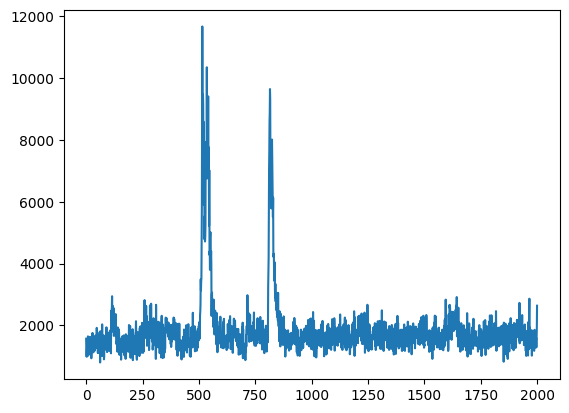

In [24]:
y_pixels, x_pixels = np.where(mask1)
trace = data[:, y_pixels[0], x_pixels[0]]
plt.plot(trace)

Plot the time series (frame 300–750) of the first pixel inside the mask 2.

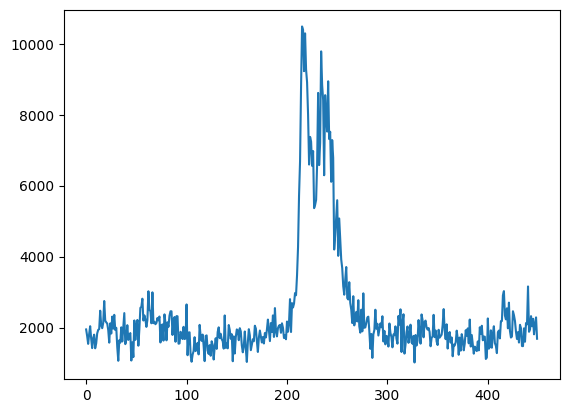

In [25]:
y_pixels, x_pixels = np.where(mask2)
trace = data[300:750, y_pixels[0], x_pixels[0]]
plt.plot(trace)

Plot the time series of the last pixel inside the mask 3.

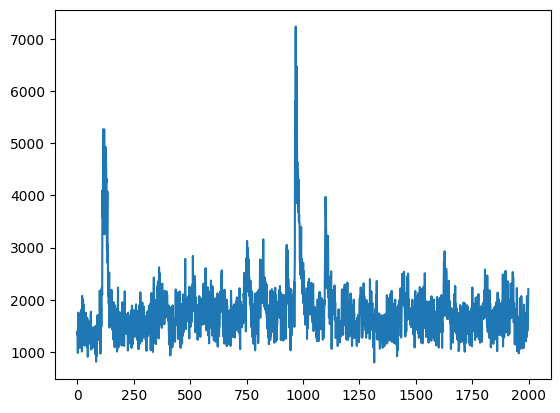

In [26]:
y_pixels, x_pixels = np.where(mask3)
trace = data[:, y_pixels[-1], x_pixels[-1]]
plt.plot(trace)

*How do I extract calcium traces from all of the active pixels?*

**Example** How many pixel traces are extracted from mask 1?

In [30]:
y_pixels, x_pixels = np.where(mask1)
traces1 = data[:, y_pixels, x_pixels]
traces1.shape

(2000, 24)

How many pixel traces are extracted from mask 2?

In [31]:
y_pixels, x_pixels = np.where(mask2)
traces2 = data[:, y_pixels, x_pixels]
traces2.shape

(2000, 13)

How many pixel traces are extracted from mask 3?

In [32]:
y_pixels, x_pixels = np.where(mask3)
traces3 = data[:, y_pixels, x_pixels]
traces3.shape

(2000, 114)

## **Averaging Pixel Values to Create a 1D Trace**  

With the pixel-wise fluorescence time series in hand, we now reduce this information to a single trace that summarizes the cell's activity. This is commonly done by averaging the fluorescence across all pixels in the ROI at each time point. This section shows how to compute and visualize a mean trace using `numpy`. 

| **Code**                               | **Description**                                                                                                  |
| :------------------------------------- | :--------------------------------------------------------------------------------------------------------------- |
| `np.mean(traces1, axis=1)` | Compute the **mean trace** across all pixels for each **time point** |


In [33]:
y_pixels, x_pixels = np.where(mask1)
cell1 = mask1.copy()

y_pixels, x_pixels = np.where(mask2)
cell2 = mask2.copy()


y_pixels, x_pixels = np.where(mask3)
cell3 = mask3.copy()

*How do I get cell trace averaging all the traces from pixels?*

`traces1`, `traces2`, and `traces3` contain the time series of all pixels defined by `mask1`, `mask2`, and `mask3`.

**Example** Plot the mean cell trace from all pixels defined by mask 1.

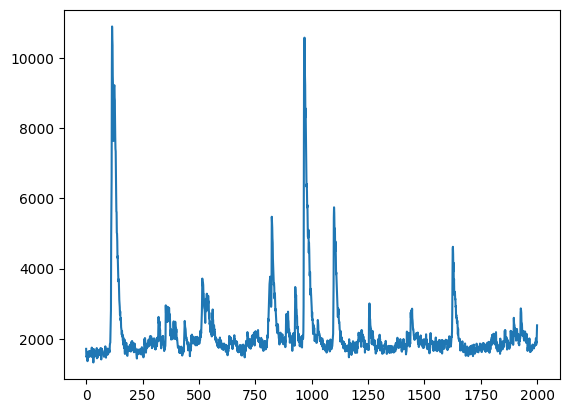

In [34]:
avg_trace = np.mean(traces1, axis=1)
plt.plot(avg_trace)

Plot the median cell trace from all pixels defined by mask 1.

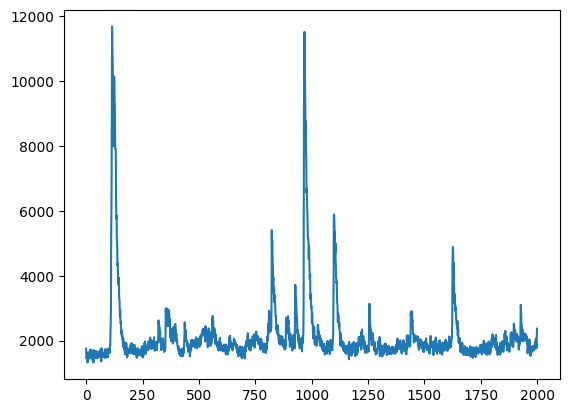

In [35]:
avg_trace = np.median(traces1, axis=1)
plt.plot(avg_trace)

Plot the mean cell trace from all pixels defined by mask 3.

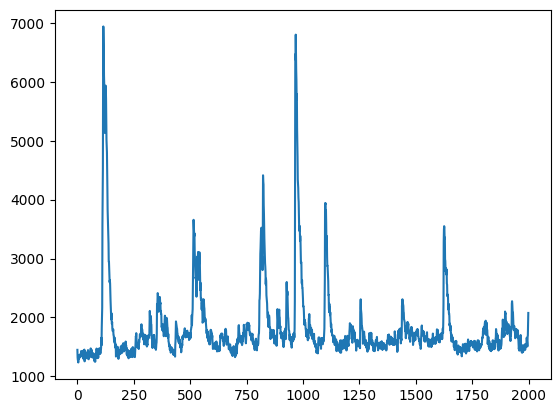

In [36]:
avg_trace = np.mean(traces3, axis=1)
plt.plot(avg_trace)

*How do I get neuropil trace?*

**Example** Obtain neuropil trace for mask 1 from ring 1px wide and 7px away.

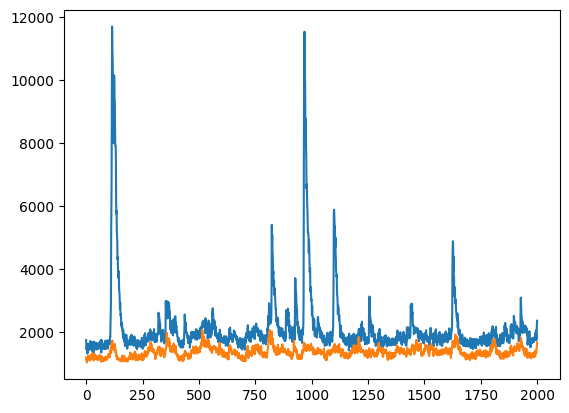

In [37]:
# cell pixels
y_pixels, x_pixels = np.where(mask1)
traces = data[:, y_pixels, x_pixels]

# neuropil pixels
y_npil, x_npil = np.where(npil)
outer = dilation(mask1, disk(8))
inner = dilation(mask1, disk(7))
npil = outer & ~inner
npil_traces = data[:, y_npil, x_npil]

# plotting average cell and neuropil traces
plt.plot(np.median(traces, axis=1))
plt.plot(np.median(npil_traces, axis=1))

Obtain neuropil trace for mask 3 from ring 1px wide and 1px away.

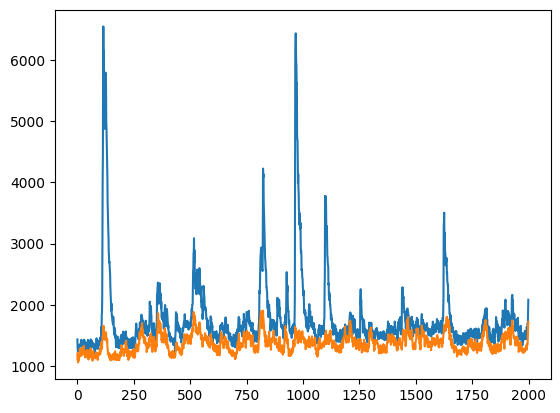

In [42]:
# cell pixels
y_pixels, x_pixels = np.where(mask3)
traces = data[:, y_pixels, x_pixels]

# neuropil pixels
y_npil, x_npil = np.where(npil)
outer = dilation(mask3, disk(2))
inner = dilation(mask3, disk(1))
npil = outer & ~inner
npil_traces = data[:, y_npil, x_npil]

# plotting average cell and neuropil traces
plt.plot(np.median(traces, axis=1))
plt.plot(np.median(npil_traces, axis=1))

Obtain neuropil trace for mask 3 from ring 3px wide and 2px away.

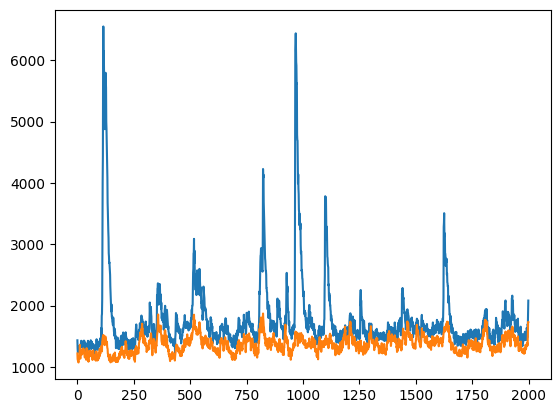

In [45]:
# cell pixels
y_pixels, x_pixels = np.where(mask3)
traces = data[:, y_pixels, x_pixels]

# neuropil pixels
y_npil, x_npil = np.where(npil)
outer = dilation(mask3, disk(5))
inner = dilation(mask3, disk(2))
npil = outer & ~inner
npil_traces = data[:, y_npil, x_npil]

# plotting average cell and neuropil traces
plt.plot(np.median(traces, axis=1))
plt.plot(np.median(npil_traces, axis=1))

## **Using Weighted and Robust Aggregation Methods**  

While averaging is often sufficient, not all pixels in the ROI may contribute equally to the signal. Some may be on the edge, poorly illuminated, or contain more noise. Weighted aggregation methods can improve the quality of the final trace by accounting for pixel-level differences. In this section, we introduce weighted averaging using `numpy` to compute a single representative fluorescence trace by taking a weighted average of multiple pixel traces, where the weights are proportional to the average brightness of each pixel. This is done by

- Compute the average fluorescence intensity over time for each pixel trace.
- Use these average values to determine weights and normalize them.
- Apply the weights to combine all pixel traces into a single weighted-average trace, where more active pixels contribute more strongly.

| **Code**                                        | **Description**                                                                                                                                              |
| :---------------------------------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `np.mean(traces1, axis=0)`                      | Compute the **mean trace** for each pixel across all frames (axis 0 corresponds to the frames). The result will be a 1D array with one mean value per pixel. |
| `np.zeros_like(mask1, dtype=float)`             | Create an array of **zeros** with the same shape as `mask1`, but with a **float** data type.                                                                 |
| `plt.colorbar()`                                | Display a **colorbar** for the current plot to indicate the scale of values.                                                                                 |
| `np.average(traces1, axis=1, weights=weights1)` | Compute the **weighted average** of `traces1` using weights1 of each pixel.                |

In [46]:
y_pixels1, x_pixels1 = np.where(mask1)
traces1 = data[:, y_pixels1, x_pixels1]

y_pixels2, x_pixels2 = np.where(mask2)
traces2 = data[:, y_pixels2, x_pixels2]

y_pixels3, x_pixels3 = np.where(mask3)
traces3 = data[:, y_pixels3, x_pixels3]

*How do I assign weights for pixels depending on how bright it is?*

**Example** Visualize pixel-wise weights for a region by normalizing the mean fluorescence intensity of each pixel in mask1.

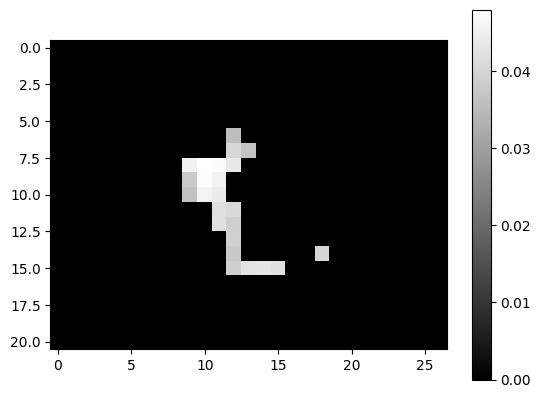

In [47]:
means1 = np.mean(traces1, axis=0)
weights1 = means1 / np.sum(means1)

weights_image = np.zeros_like(mask1, dtype=float)
y_pixels1, x_pixels1 = np.where(mask1)
weights_image[y_pixels1, x_pixels1] = weights1

plt.imshow(weights_image, cmap='gray')
plt.colorbar()

Visualize pixel-wise weights for a region by normalizing the mean fluorescence intensity of each pixel in mask2.

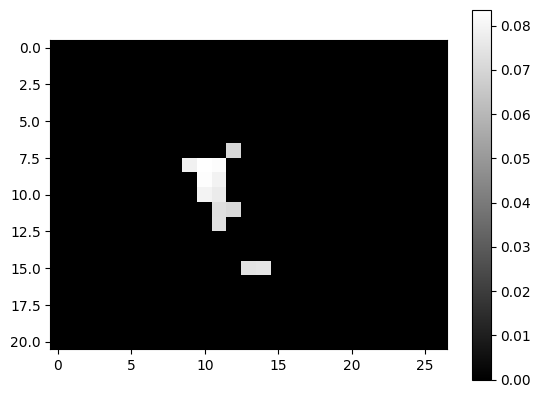

In [48]:
means2 = np.mean(traces2, axis=0)
weights2 = means2 / np.sum(means2)

weights_image = np.zeros_like(mask2, dtype=float)
y_pixels2, x_pixels2 = np.where(mask2)
weights_image[y_pixels2, x_pixels2] = weights2

plt.imshow(weights_image, cmap='gray')
plt.colorbar()

Visualize pixel-wise weights for a region by normalizing the mean fluorescence intensity of each pixel in mask3.

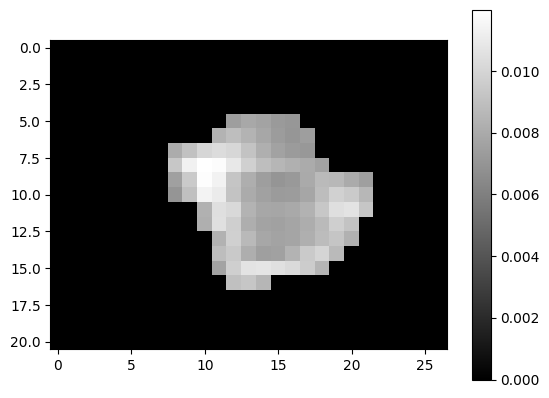

In [49]:
means3 = np.mean(traces3, axis=0)
weights3 = means3 / np.sum(means3)

weights_image = np.zeros_like(mask3, dtype=float)
y_pixels3, x_pixels3 = np.where(mask3)
weights_image[y_pixels3, x_pixels3] = weights3

plt.imshow(weights_image, cmap='gray')
plt.colorbar()

*How do I get weighted average?*

**Example** Plot the weighted average time series of pixels in mask1.

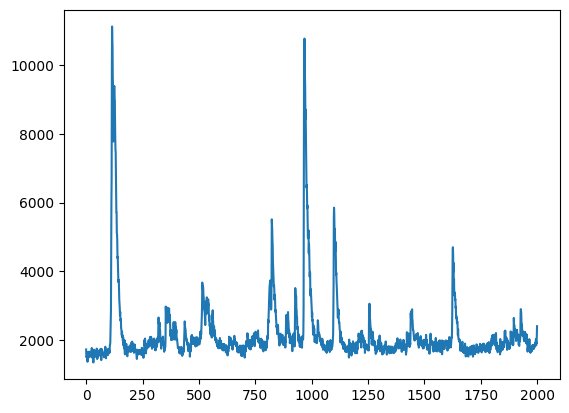

In [50]:
weighted_trace1 = np.average(traces1, axis=1, weights=weights1)
plt.plot(weighted_trace1)

Plot the weighted average time series of pixels in mask2.

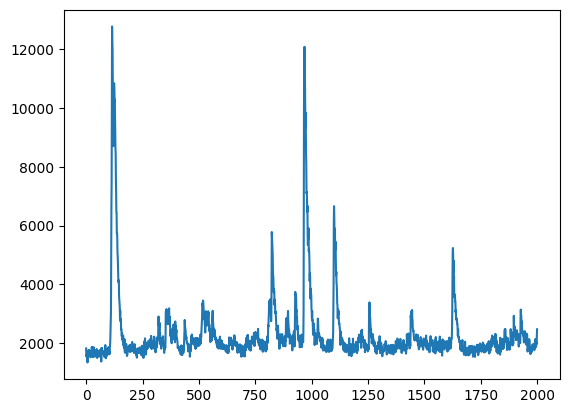

In [51]:
weighted_trace = np.average(traces2, axis=1, weights=weights2)
plt.plot(weighted_trace)

Plot the weighted average time series of pixels in mask3.

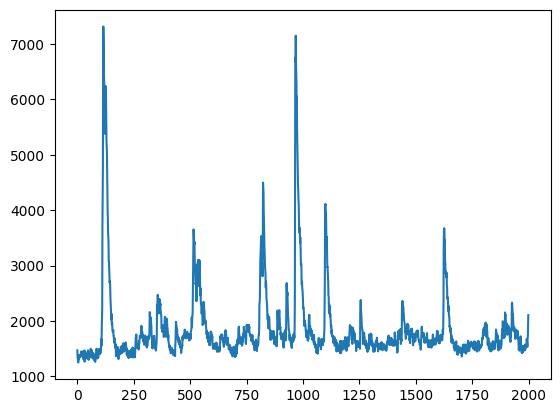

In [52]:
weighted_trace = np.average(traces3, axis=1, weights=weights3)
plt.plot(weighted_trace)

**Bonus** Compare traces obtained with and without doing weighted average